# Detailed Example with Step by Step Procedure of Every Functions

This notebook serves as the demonstration in detail of every functions from the brief example demonstrated on 'Brief_EXAMPLE'.

## Initial Imports

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import re

## Part 1 (Essential): User Input & Pre-processing part
Load the necessary libraries for data processing, visualization, and mathematical operations. Load the battery data from the specified folder and perform initial grouping by cycles.

In [19]:
#----------------------------------Data input----------------------------------
data_folder = 'DA_Data'                                                        # <=== Insert folder of the data file(s)
result_folder = 'DA_Result'                                                    # <=== Insert folder for result
file_name = 'N1T1'                                                            # <=== Insert file name
rated_capacity = 2100                                                          # <=== Insert rated capacity of battery

### Data Import & Conditioning (Function calling: DA00_Function_Import)
First, start by looping through all the TXT files, then compile them into one DataFrame (df_main).

In [20]:
#---------------------------------Data Import----------------------------------
# df_main = DA00_Function_Import(data_folder,file_name,rated_capacity)
    
# def DA00_Function_Import(data_folder,file_name,rated_capacity):
    # Import multiple Neware txt files, loop until all files found, remove 
    # tab and header using skiprows, remove index and "." as decimal
    
df_main = []
i = 0  # Start counter

while True:
    # Correctly construct the file path
    file_path = f"{data_folder}/{file_name}/{file_name}__{i}.txt"
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the file
        dataraw = pd.read_csv(file_path, sep='\t', skiprows=0, index_col=False, decimal='.')
        df_main.append(dataraw)  # Append dataframe to the list
        i += 1  # Increment counter for the next file
    else:
        print(f"File {file_path} not found. Stopping.")
        break  # Exit loop when the file is not found

# Create one main dataframe by combining the loop import files
df_main = pd.concat(df_main, ignore_index=True)

File DA_Data/N1T1/N1T1__11.txt not found. Stopping.


Then, renaming the column label into simpler and non-sensitive naming, while also condition the data form into timedelta for 'Time' and process the 'Cycle_Time' as the time counter thoughout individual cycle.

In [21]:
# change column names
name_conversion_dict = {'Time(h:min:s.ms)': 'Time', 'Voltage(V)':'Voltage', 'Current(mA)': 'Current', 'Energy(mWh)': 'Energy', 'Capacity(mAh)': 'Capacity', 'dQ/dV(mAh/V)':'dQdV'}
df_main = df_main.rename(columns=name_conversion_dict)

# Convert 'Time' to timedelta (duration) for cumulative addition
df_main['Time'] = pd.to_timedelta(df_main['Time'].astype(str))
    
# Sort data properly: First by 'Cycle ID', then 'Record ID', then 'Time'
df_main = df_main.sort_values(by=['Cycle ID', 'Record ID', 'Time']).reset_index(drop=True)

# Compute Time difference within each cycle
df_main['Time_Diff'] = df_main.groupby('Cycle ID')['Time'].diff().fillna(pd.Timedelta(seconds=0))

# Ensure no negative values (set negatives to 0)
df_main['Time_Diff'] = df_main['Time_Diff'].apply(lambda x: max(x.total_seconds(), 0))  # Convert to milliseconds

# Compute Cycle_Time as the cumulative sum of Time_Diff within each cycle
df_main['Cycle_Time'] = df_main.groupby('Cycle ID')['Time_Diff'].cumsum() 

# Add 'Power' with multiplication of voltage and current
df_main.insert(df_main.columns.get_loc("Capacity") + 1, "Power", df_main["Voltage"] * df_main["Current"])
    
# DataFrame Preview
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_main preview: ',df_main.head(5))
   
    # return df_main

DataFrame df_main preview:     Cycle ID  Step ID Step Name  Record ID                   Time  Voltage  \
0         1        1      Rest          1        0 days 00:00:00   3.5639   
1         1        1      Rest          2 0 days 00:00:00.100000   3.5639   
2         1        1      Rest          3 0 days 00:00:00.500000   3.5639   
3         1        1      Rest          4        0 days 00:00:01   3.5639   
4         1        1      Rest          5 0 days 00:00:01.500000   3.5639   

   Current  Capacity  Power  Energy             Realtime  dQdV  Time_Diff  \
0      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.0   
1      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.1   
2      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.4   
3      0.0       0.0    0.0     0.0  10/18/2024 14:12:50   0.0        0.5   
4      0.0       0.0    0.0     0.0  10/18/2024 14:12:51   0.0        0.5   

   Cycle_Time  
0         0.0  
1         0.1 

### Data Grouping by Cycle

From the compiled data, grouping by the cycle as one dataframe, and drop any unnecessary columns. Preview of DataFrame (df_cycle_grouped) is shown on the following output.

In [22]:
# ----------------------------Data Grouping by Cycle----------------------------
# Grouping based on cycle, combining CC Chg & CV Chg into one Chg data
# df_cycle_grouped,df_VQ_grouped = DA00_Function_df_Cycle_Grouping(df_main,
#                                                                  result_folder,
#                                                                  file_name)
#----------------------------Grouping in Dataframe-----------------------------
# def DA00_Function_df_Cycle_Grouping(df_main,result_folder,file_name):

#Make result folder
os.makedirs(f"{result_folder}/{file_name}", exist_ok=True)  
print(f"Folder '{result_folder}/{file_name}' created!")

# Dropping unnecessary columns
df_cycle_grouped = df_main.drop(columns=['Time','Realtime','Time_Diff'])
    
# Grouping dataframe by Cycle ID, cycle_id = the cycle numbers
df_cycle_grouped = df_cycle_grouped.groupby('Cycle ID')
cycle_id = df_cycle_grouped.groups.keys()
print("The cycles imported from", file_name, "are:", cycle_id, "and pre-processed.")

pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_cycle_grouped preview: ')
print(df_cycle_grouped.head(5))

Folder 'DA_Result/N1T1' created!
The cycles imported from N1T1 are: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) and pre-processed.
DataFrame df_cycle_grouped preview: 
        Cycle ID  Step ID Step Name  Record ID  Voltage  Current  Capacity  \
0              1        1      Rest          1   3.5639     0.00      0.00   
1              1        1      Rest          2   3.5639     0.00      0.00   
2              1        1      Rest          3   3.5639     0.00      0.00   
3              1        1      Rest          4   3.5639     0.00      0.00   
4              1        1      Rest          5   3.5639     0.00      0.00   
73122          2        7    CC_Chg      73123   3.1420   419.89      0.00   
73123          2        7    CC_Chg      73124   3.1420   419.89      0.01   
73124          2        7    CC_Chg      73125   3.1482   419.95      0.06   
73125          2        7    CC_Chg      73126   3.1522   420.01      0.12   
73126          2        7    CC_Chg      73127   3.15

### Extract V & Cap data

Another dataframe to extract voltage and capacity data, while beforehand make charge capacity continuous value between CC_Chg and CV_Chg by extracting the step through 'Step Name' column. The end capacity value of CC_Chg will be the starting capacity value for CV_Chg. Preview of DataFrame (df_VQ_grouped) is shown on the following output.

In [23]:
# Initialize an empty list to store data for each cycle
df_VQ_grouped_list = []

# Function to add CC_Chg to CV_Chg capacity (as initial capacity)
def accumulate_capacity(df, start_capacity):
    df['Accumulated_Capacity'] = df['Capacity'] + start_capacity
    return df

# Iterate over each cycle
for cycle_id, df_cyc in df_cycle_grouped:
        
    # Group by Step Name within each cycle
    df_step_grouped = df_cyc.groupby('Step Name')
    step_group_name = df_step_grouped.groups.keys()
       
    if 'CC_Chg' and 'CV_Chg' and 'CC_DChg' in step_group_name:
            
        # Extract relevant steps
        cc_chg = df_step_grouped.get_group('CC_Chg') if 'CC_Chg' in df_step_grouped.groups else pd.DataFrame()
        cv_chg = df_step_grouped.get_group('CV_Chg') if 'CV_Chg' in df_step_grouped.groups else pd.DataFrame()
        cc_dchg = df_step_grouped.get_group('CC_DChg') if 'CC_DChg' in df_step_grouped.groups else pd.DataFrame()
            
        # Voltage and Capacity for Charge steps
        vchg = pd.concat([cc_chg['Voltage'], cv_chg['Voltage']]) if not cv_chg.empty else cc_chg['Voltage']
        dqdvchg = pd.concat([cc_chg['dQdV'], cv_chg['dQdV']]) if not cv_chg.empty else cc_chg['dQdV']
        cchg_start = cc_chg['Capacity'].iloc[-1] if not cc_chg.empty else 0
        cchg = pd.concat([cc_chg['Capacity'], 
                          accumulate_capacity(cv_chg, cchg_start)['Accumulated_Capacity']]) if not cv_chg.empty else   cc_chg['Capacity']

        # Voltage and Capacity for Discharge steps
        vdchg = cc_dchg['Voltage'] if not cc_dchg.empty else pd.Series()
        cdchg = cc_dchg['Capacity'] if not cc_dchg.empty else pd.Series()
        dqdvdchg = cc_dchg['dQdV'] if not cc_dchg.empty else pd.Series()
        
        # Combine into a DataFrame for V-Q
        df_VQ = pd.DataFrame({
                f'Cycle_{cycle_id}_VChg': vchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_CapChg': cchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_dQdVChg': dqdvchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_VDChg': vdchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_CapDChg': cdchg.reset_index(drop=True),
                f'Cycle_{cycle_id}_dQdVDChg': dqdvdchg.reset_index(drop=True),
                })
               
        # Combine all the cycles
        df_VQ_grouped_list.append(df_VQ)

    else:
        continue
        
# Concatenate all cycle data horizontally and save the result
df_VQ_grouped = pd.concat(df_VQ_grouped_list, axis=1)
df_VQ_grouped.to_csv(f'{result_folder}/{file_name}/df_VQ_grouped_{file_name}.csv', index=False)
    
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_VQ_grouped preview: ')
print(df_VQ_grouped.head(5))
    
    # return df_cycle_grouped,df_VQ_grouped

C:\Users\hanst\AppData\Local\Temp\ipykernel_32564\4074801958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accumulated_Capacity'] = df['Capacity'] + start_capacity
C:\Users\hanst\AppData\Local\Temp\ipykernel_32564\4074801958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accumulated_Capacity'] = df['Capacity'] + start_capacity
C:\Users\hanst\AppData\Local\Temp\ipykernel_32564\4074801958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

DataFrame df_VQ_grouped preview: 
   Cycle_1_VChg  Cycle_1_CapChg  Cycle_1_dQdVChg  Cycle_1_VDChg  \
0        3.6055            0.00             0.00         4.1372   
1        3.6055            0.01             0.00         4.1372   
2        3.6064            0.06            51.85         4.1369   
3        3.6070            0.12            97.23         4.1359   
4        3.6077            0.17            83.33         4.1356   

   Cycle_1_CapDChg  Cycle_1_dQdVDChg  Cycle_2_VChg  Cycle_2_CapChg  \
0             0.00              0.00        3.1420            0.00   
1             0.01              0.00        3.1420            0.01   
2             0.06           -155.56        3.1482            0.06   
3             0.12            -58.34        3.1522            0.12   
4             0.17           -194.44        3.1547            0.17   

   Cycle_2_dQdVChg  Cycle_2_VDChg  Cycle_2_CapDChg  Cycle_2_dQdVDChg  \
0             0.00         4.1378             0.00              0.00  

## Part 2 (Selective):  Plotting, Calculating, Processing, Analysis

All the functions that lead to plotting, calculating, processing, and analysis of degradation analysis with the metrics, such as Voltage to Capacity and dQ/dV analysis, however those functions are not related to each other and could be done independently and without order.

### Voltage and Current vs Time Analysis [Direct Plotting]
Analyze the voltage and current vs time relationship across charge-discharge cycles. It is done on every cycle, one cycle one plot basis.

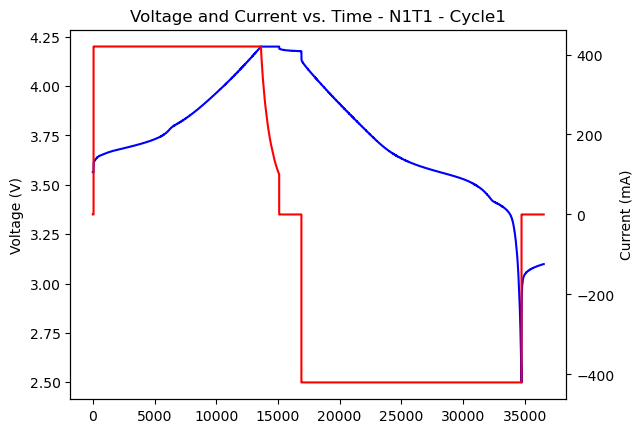

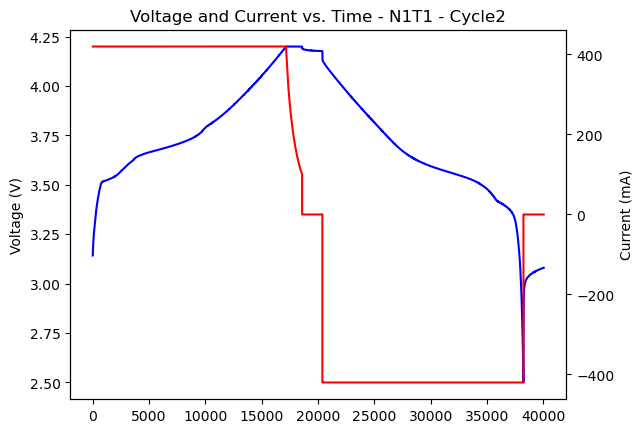

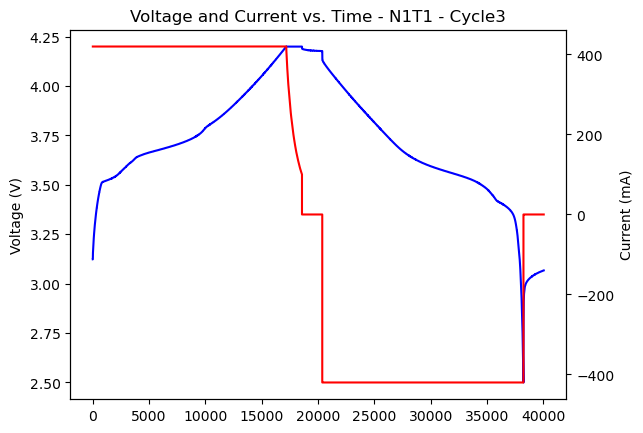

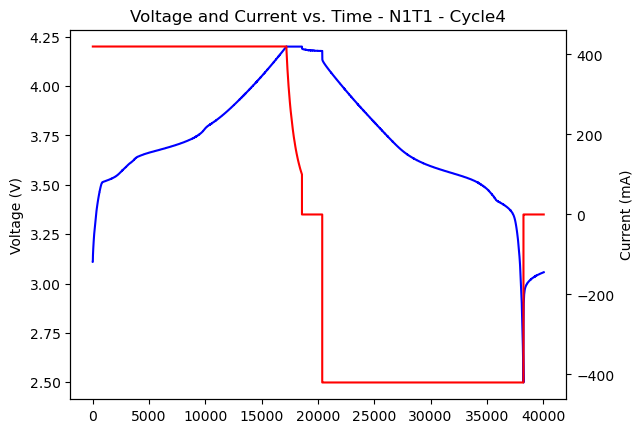

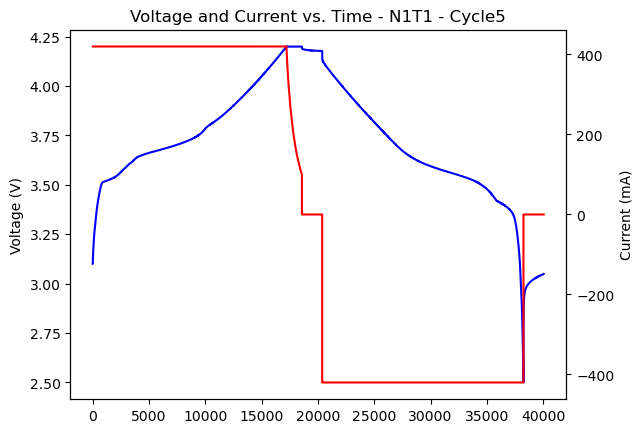

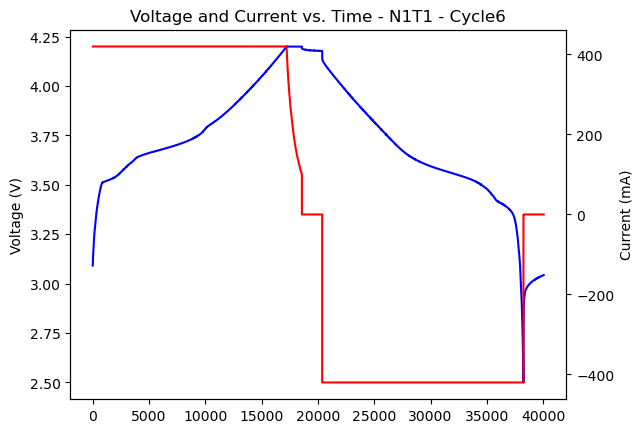

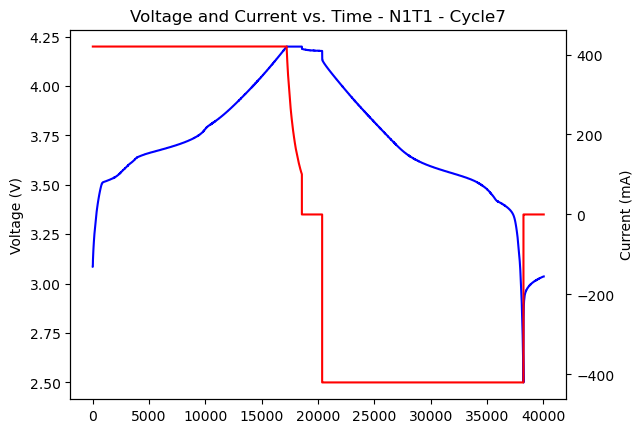

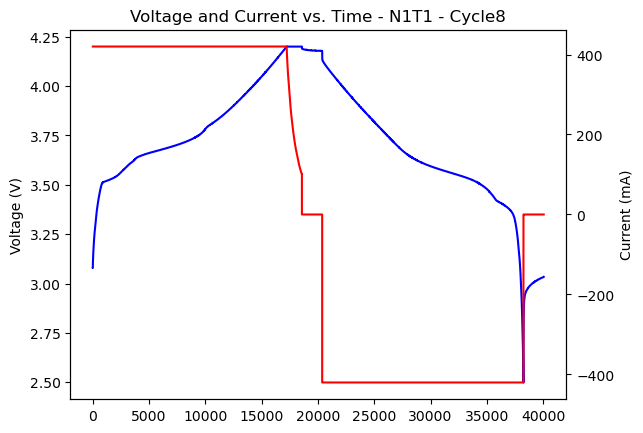

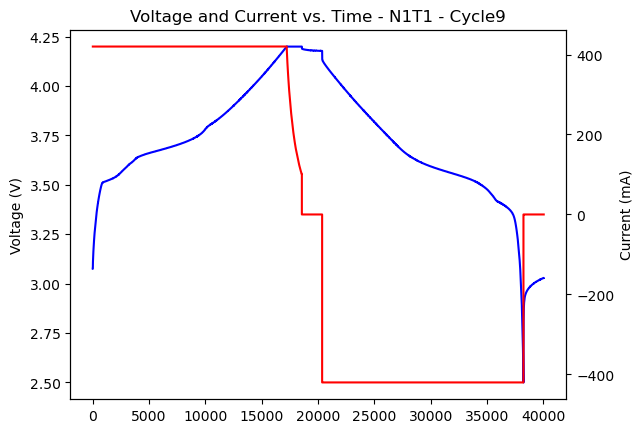

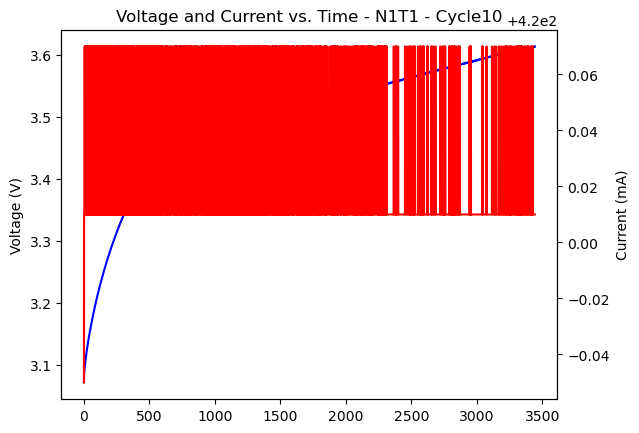

In [24]:
# DA01_Function_VnIvsTime(result_folder,file_name,df_cycle_grouped)
#-----------------------------------VnIvsTime----------------------------------
# def DA01_Function_VnIvsTime(result_folder,file_name,df_cycle_grouped):

cycle_id = df_cycle_grouped.groups.keys()
    
#---------------------------------Every cycles----------------------------- 
i = 0
for i in cycle_id:    
    cycle_data = df_cycle_grouped.get_group(i)
    fig, host = plt.subplots()
    par1 = host.twinx()

    # Insert the data for overview plot
    p1, = host.plot(cycle_data['Cycle_Time'], cycle_data['Voltage'], "b-")
    p2, = par1.plot(cycle_data['Cycle_Time'], cycle_data['Current'], "r-")
    host.set_ylabel('Voltage (V)')
    par1.set_ylabel('Current (mA)')
    plt.title(f'Voltage and Current vs. Time - {file_name} - Cycle{i}')
    plt.savefig(f'{result_folder}/{file_name}/VnCvsTime_{file_name}_Cycle{i}.png', dpi=300, bbox_inches='tight')
    plt.show()
    i += 1

And also compiled all cycles in one battery cell into one plot.

C:\Users\hanst\AppData\Local\Temp\ipykernel_32564\244244507.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  host.legend(loc='upper left')
C:\Users\hanst\AppData\Local\Temp\ipykernel_32564\244244507.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  par1.legend(loc='upper right')


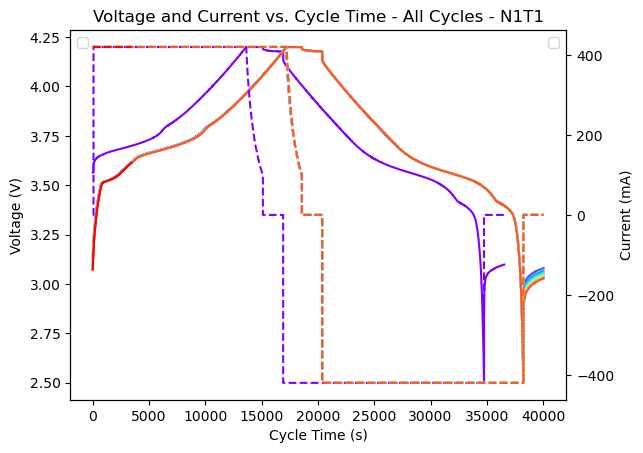

In [25]:
 #-----------------------------------All cycles-----------------------------    
fig, host = plt.subplots()
par1 = host.twinx()  # Create the second y-axis

# Get a colormap with enough colors for all cycles
colors = cm.rainbow(np.linspace(0, 1, len(cycle_id)))
    
i = 0
for i, cycle in enumerate(cycle_id):
    cycle_data = df_cycle_grouped.get_group(cycle)
      
    # Plot each cycle with a different color
    p1, = host.plot(cycle_data['Cycle_Time'], cycle_data['Voltage'], color=colors[i])#, label=f'Cycle {cycle} Voltage')
    p2, = par1.plot(cycle_data['Cycle_Time'], cycle_data['Current'], color=colors[i], linestyle='--')#, label=f'Cycle {cycle} Current')
    
# Set labels and titles
host.set_xlabel('Cycle Time (s)')
host.set_ylabel('Voltage (V)')
par1.set_ylabel('Current (mA)')
plt.title(f'Voltage and Current vs. Cycle Time - All Cycles - {file_name}')

# Create a legend that combines both axes
host.legend(loc='upper left')
par1.legend(loc='upper right')

# Save the combined plot
plt.savefig(f"{result_folder}/{file_name}/VnCvsTime_{file_name}_AllCycles.png", dpi=300, bbox_inches='tight')
plt.show()

    # return

### Power Analysis [Direct Plotting]

Analyze the power vs time relationship across charge-discharge cycles. It is done on every cycle, one cycle one plot basis.

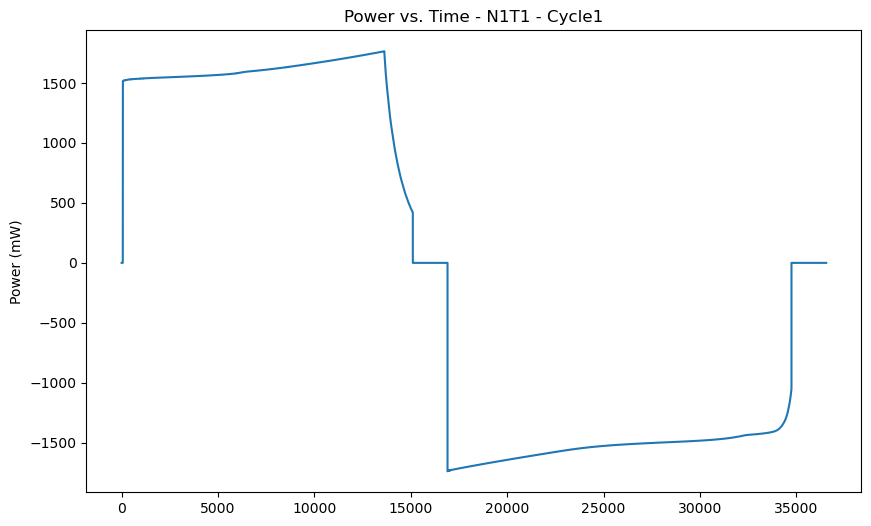

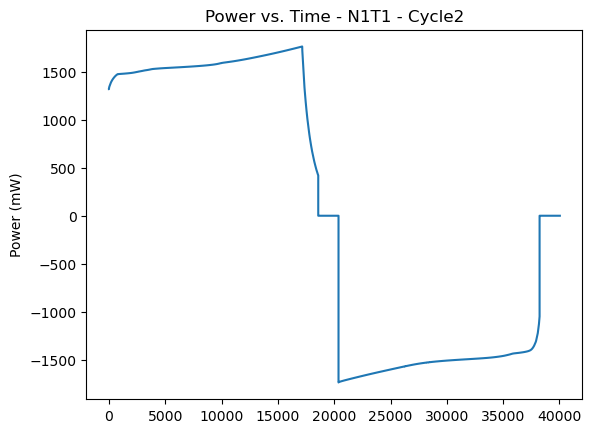

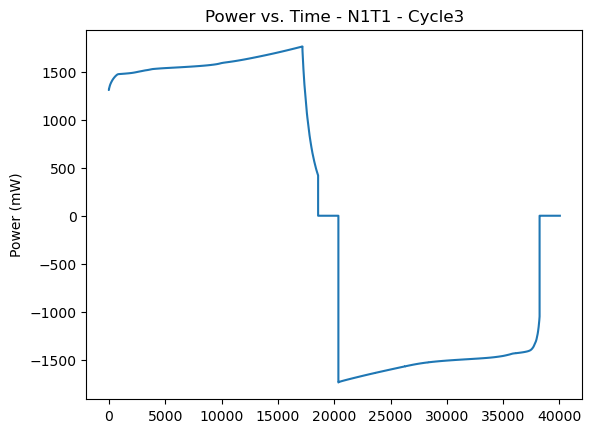

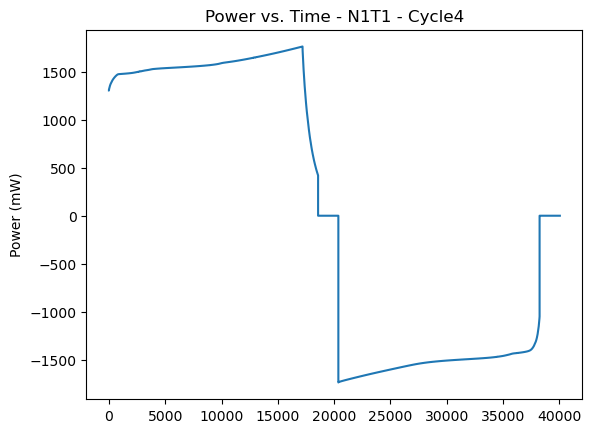

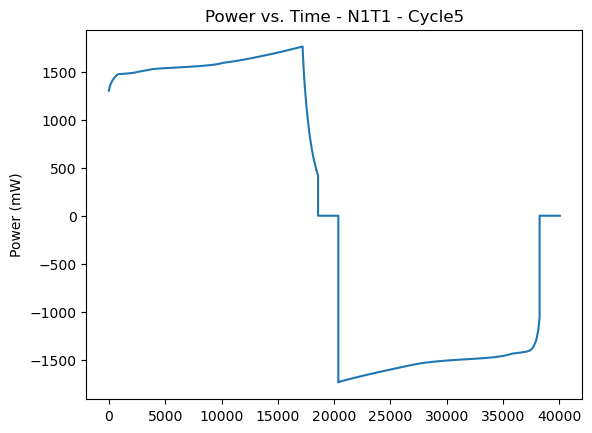

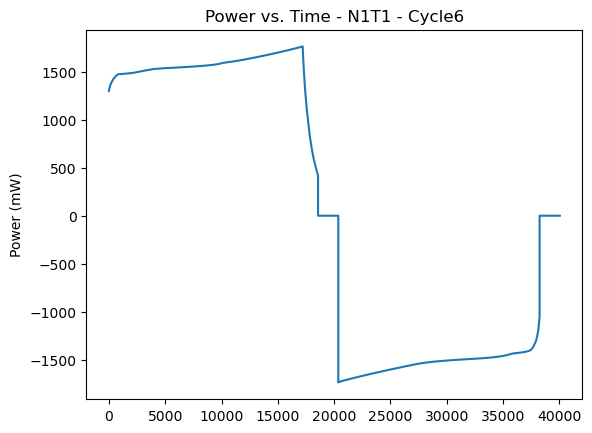

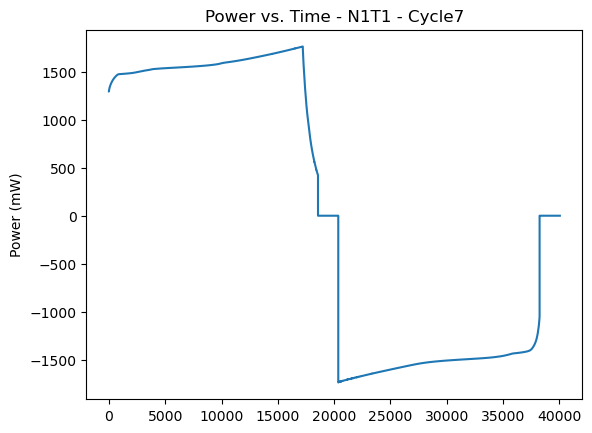

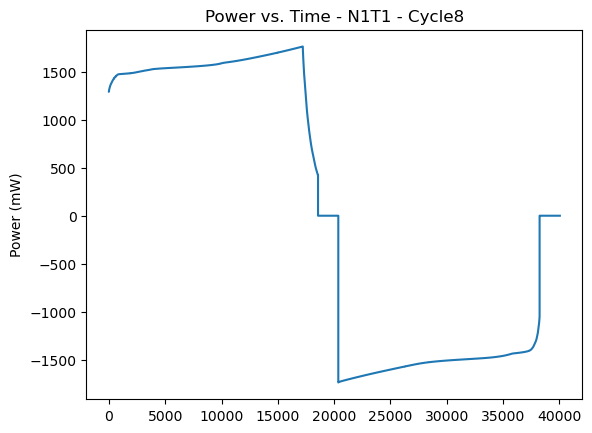

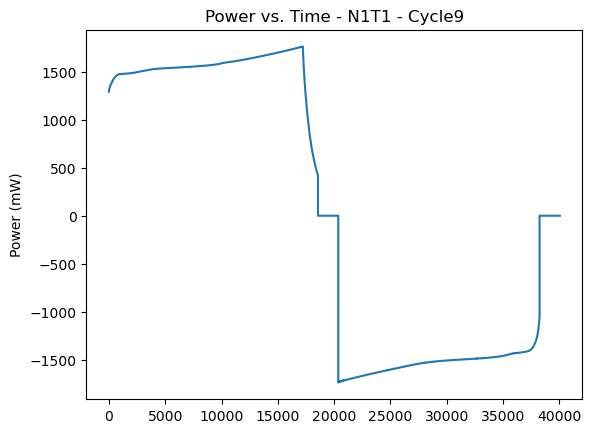

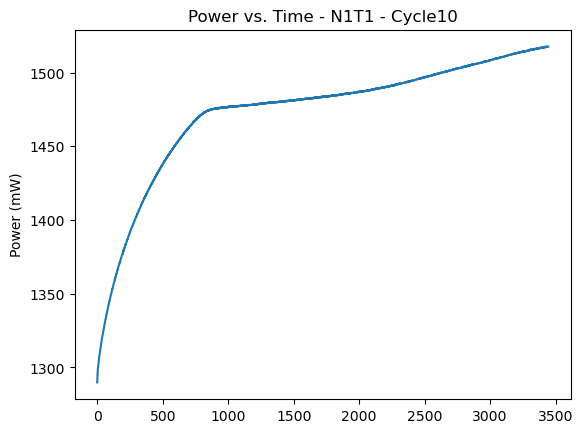

In [26]:
    # DA01_Function_Power(result_folder,file_name,df_cycle_grouped)
#------------------------------------Power-------------------------------------
# def DA01_Function_Power(result_folder,file_name,df_cycle_grouped):
    cycle_id = df_cycle_grouped.groups.keys()
    
#---------------------------------Every cycles----------------------------
    plt.figure(figsize=(10, 6))
    i = 0
    for i in cycle_id:
        cycle_data = df_cycle_grouped.get_group(i)

        # Insert the data for overview plot
        plt.plot(cycle_data['Cycle_Time'], cycle_data['Power'])
        plt.ylabel('Cycle Time (s)')
        plt.ylabel('Power (mW)')
        plt.title(f'Power vs. Time - {file_name} - Cycle{i}')
        plt.savefig(f'{result_folder}/{file_name}/PvsTime_{file_name}_Cycle{i}.png', dpi=300, bbox_inches='tight')
        plt.show()
        i += 1

And also compiled all cycles in one battery cell into one plot.

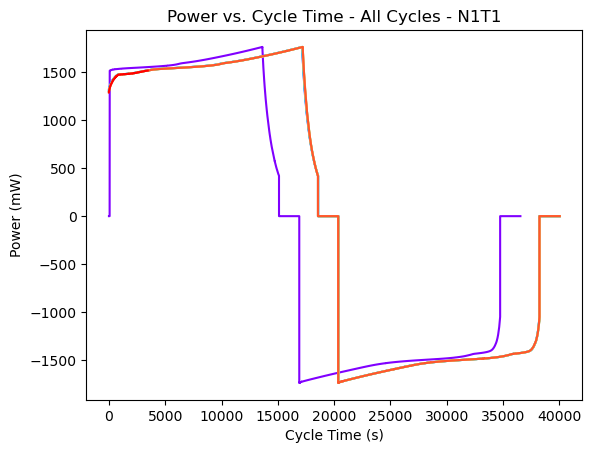

In [27]:
#-----------------------------------All cycles-----------------------------    
# Get a colormap with enough colors for all cycles
colors = cm.rainbow(np.linspace(0, 1, len(cycle_id)))

for i, cycle in enumerate(cycle_id):
    cycle_data = df_cycle_grouped.get_group(cycle)
        
    # Plot each cycle with a different color
    plt.plot(cycle_data['Cycle_Time'], cycle_data['Power'], color=colors[i])
    
# Set labels and titles
plt.xlabel('Cycle Time (s)')
plt.ylabel('Power (mW)')
plt.title(f'Power vs. Cycle Time - All Cycles - {file_name}')
plt.savefig(f"{result_folder}/{file_name}/PvsTime_{file_name}_AllCycles.png", dpi=300, bbox_inches='tight')
plt.show()

    # return

### Voltage vs Capacity Analysis [Direct Plotting]

Analyze the voltage vs capacity relationship across charge-discharge cycles.

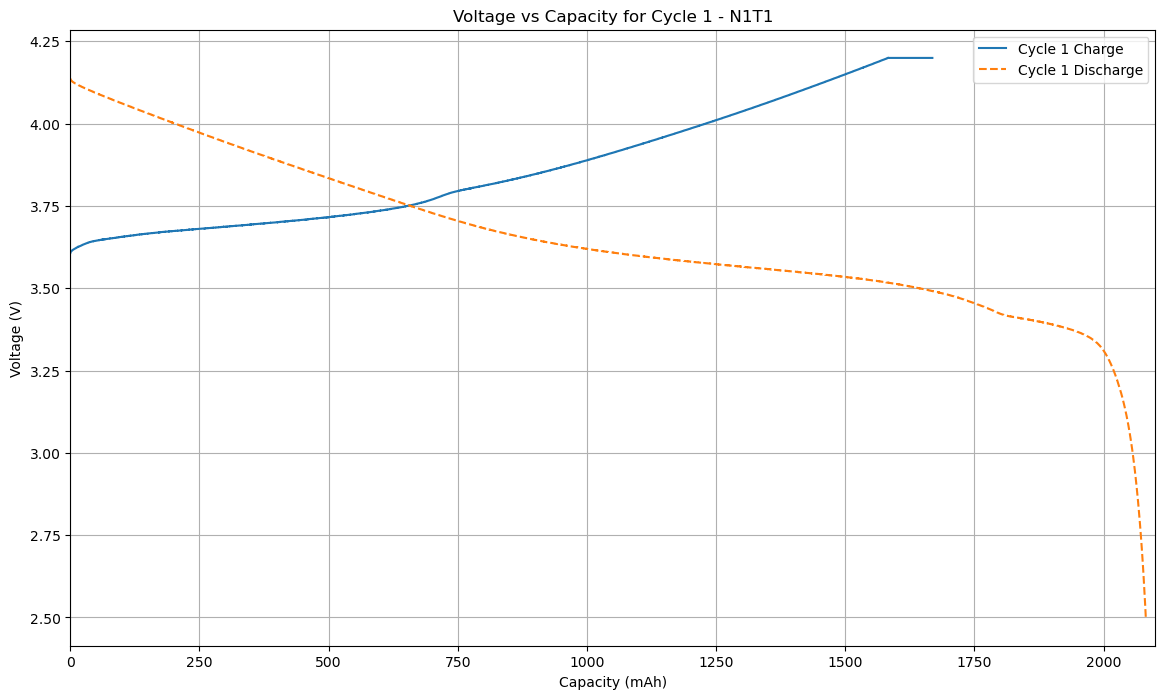

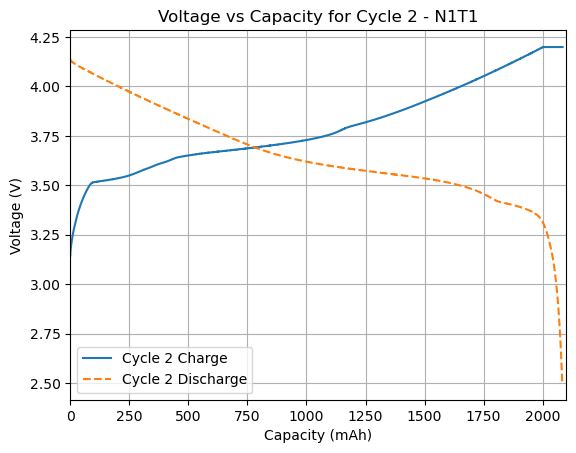

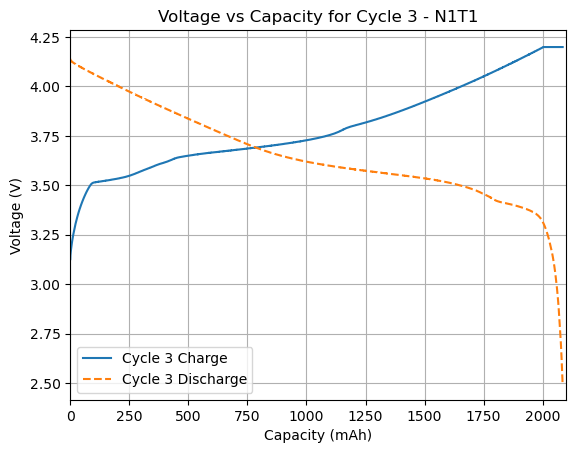

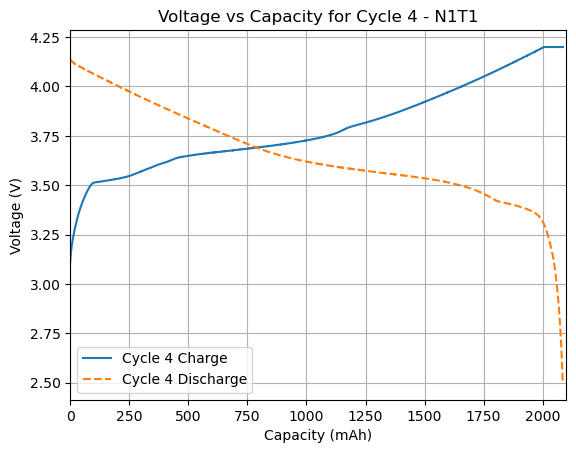

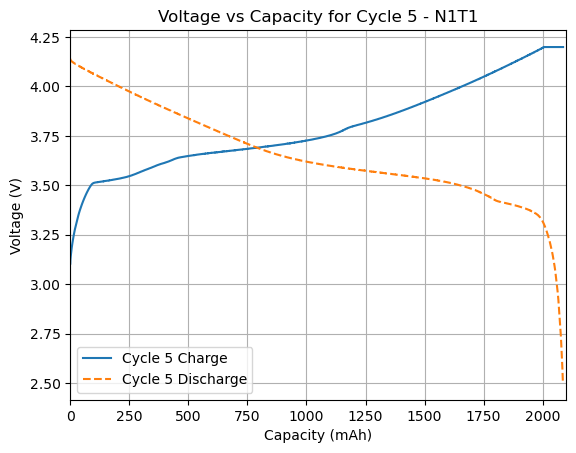

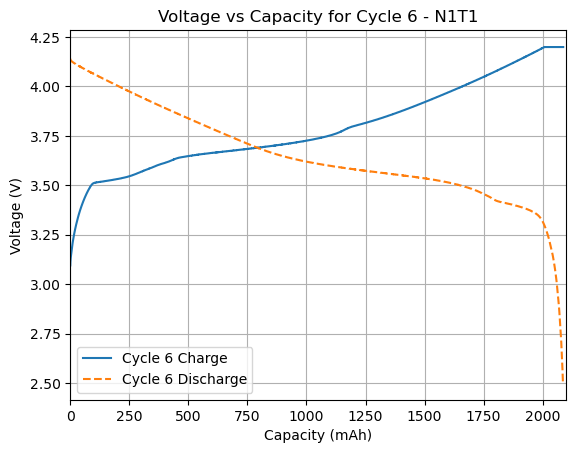

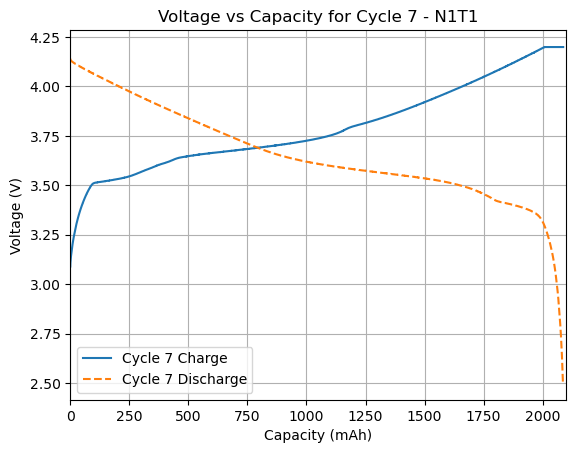

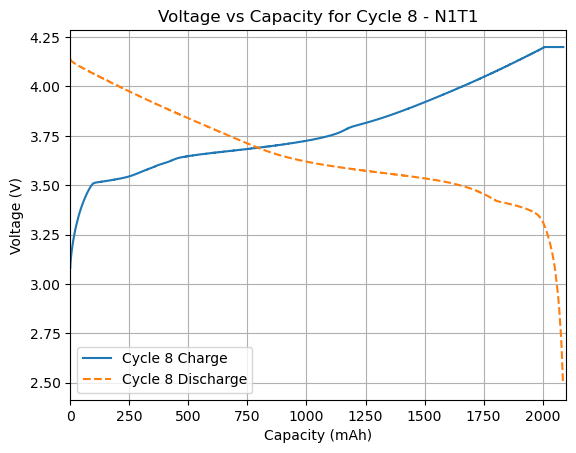

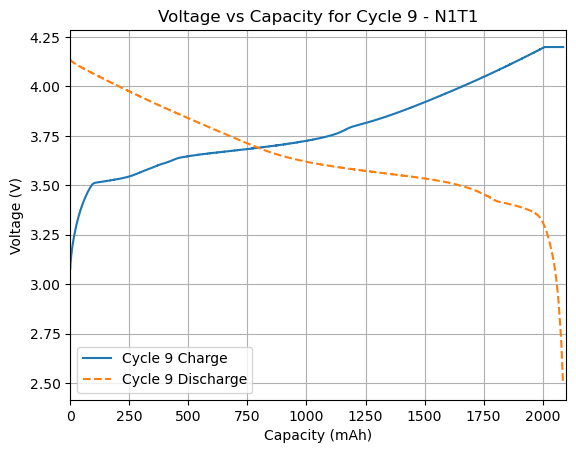

In [28]:
# DA02_Function_VvsCap(df_VQ_grouped,file_name,result_folder,rated_capacity)
#--------------------Plotting Voltage to Capacity (VvsCap)---------------------
# def DA02_Function_VvsCap(df_VQ_grouped,file_name,result_folder,rated_capacity):  
    
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})
    
#----------------------------Plot Every Cycles-----------------------------
plt.figure(figsize=(14, 8))

for idx, cycle_id in enumerate(cycle_numbers):

    # Plot Charge V-Q
    if f'Cycle_{cycle_id}_VChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'], 
                 df_VQ_grouped[f'Cycle_{cycle_id}_VChg'], label=f'Cycle {cycle_id} Charge')

    # Plot Discharge V-Q
    if f'Cycle_{cycle_id}_VDChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapDChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'],
                 df_VQ_grouped[f'Cycle_{cycle_id}_VDChg'], linestyle='--', 
                 label=f'Cycle {cycle_id} Discharge')
        
    plt.xlabel('Capacity (mAh)')
    plt.ylabel('Voltage (V)')
    plt.xlim(0, rated_capacity)
    plt.title(f'Voltage vs Capacity for Cycle {cycle_id} - {file_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{result_folder}/{file_name}/V-Q_Cycle_{cycle_id}_{file_name}.png')
    plt.show()

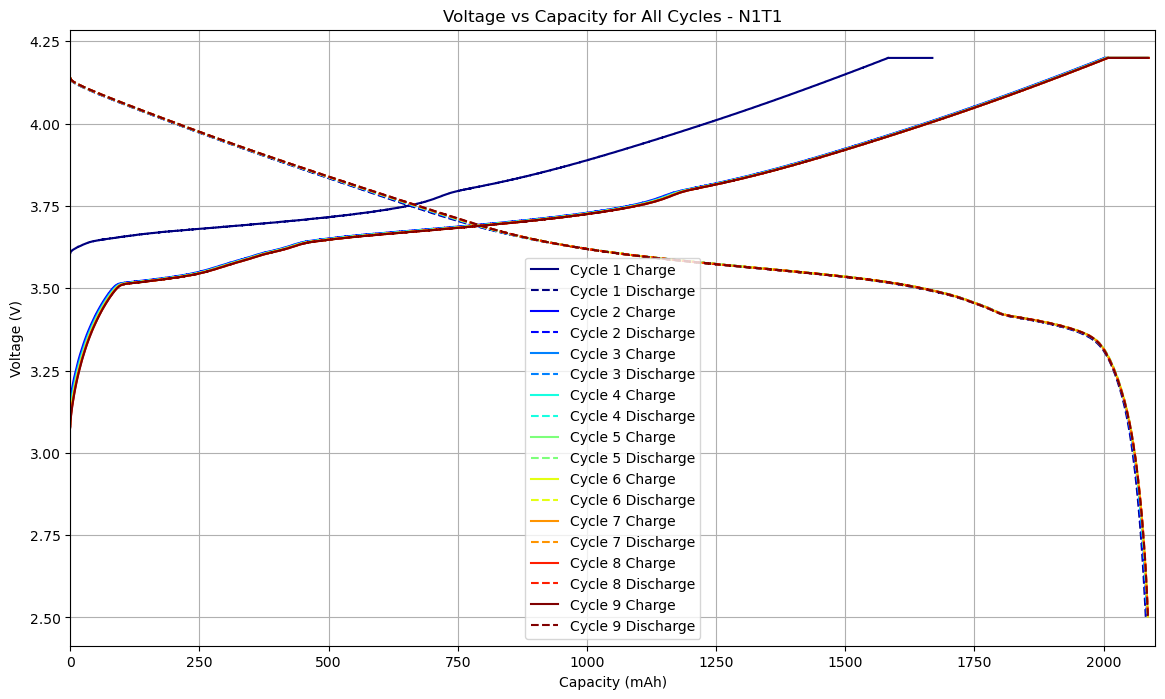

In [29]:
#-----------------------------Plot All Cycles------------------------------
# Plot V-Q for all cycles in one graph with different colors
plt.figure(figsize=(14, 8))

# Define a color map
colors = plt.cm.jet(np.linspace(0, 1, len(cycle_numbers)))

for idx, cycle_id in enumerate(cycle_numbers):
    color = colors[idx]

    # Plot Charge V-Q
    if f'Cycle_{cycle_id}_VChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'], 
                 df_VQ_grouped[f'Cycle_{cycle_id}_VChg'], label=f'Cycle {cycle_id} Charge', 
                 color=color)

    # Plot Discharge V-Q
    if f'Cycle_{cycle_id}_VDChg' in df_VQ_grouped and f'Cycle_{cycle_id}_CapDChg' in df_VQ_grouped:
        plt.plot(df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'],
                 df_VQ_grouped[f'Cycle_{cycle_id}_VDChg'], linestyle='--', 
                 label=f'Cycle {cycle_id} Discharge', color=color)

plt.xlabel('Capacity (mAh)')
plt.ylabel('Voltage (V)')
plt.xlim(0, rated_capacity)
plt.title(f'Voltage vs Capacity for All Cycles - {file_name}')
plt.legend()
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/V-Q_All_Cycles_{file_name}.png')   
plt.show()
    
   # return

### Coulombic Efficiency (CE) Analysis [Processing & Plotting]

Calculate the coulombic efficiency of the battery over cycles by dividing maximum discharging capacity by maximum charging capacity. Preview of DataFrame (df_ce) is shown on the following output.

In [30]:
# df_ce = DA03_Function_Coulombic_Efficiency(df_VQ_grouped,file_name,result_folder)
#---------------------Processing & Plotting CE over cycles---------------------
# def DA03_Function_Coulombic_Efficiency(df_VQ_grouped,file_name,result_folder):   

ce_cycle = []
    
# Extract unique cycle numbers from the column names
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})

for cycle_id in cycle_numbers:
       
    cchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'].dropna()
    cdchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'].dropna()
      
    # Calculate Coulombic Efficiency (CE)
    total_CapChg = cchg.iloc[-1] if not cchg.empty else 0
    total_CapDChg = cdchg.iloc[-1] if not cdchg.empty else 0
    ce = (total_CapDChg / total_CapChg) * 100 if total_CapChg > 0 else 0
    if ce > 100:
        continue
        
    # Combine into a DataFrame
    ce_cycle.append({
        'Cycle_ID': cycle_id,
        'Discharge_Capacity': total_CapDChg,
        'Charge_Capacity': total_CapChg,
        'Coulombic_Efficiency': ce,
        })
               
# Create a DataFrame for Coulombic Efficiencies and save the result
df_ce = pd.DataFrame(ce_cycle)
df_ce.to_csv(f'{result_folder}/{file_name}/df_CE_{file_name}.csv', index=False)
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_ce preview: ',df_ce.head(5))

DataFrame df_ce preview:     Cycle_ID  Discharge_Capacity  Charge_Capacity  Coulombic_Efficiency
0         2             2082.97          2084.35             99.933792
1         3             2084.21          2084.74             99.974577
2         4             2085.16          2085.93             99.963086
3         5             2085.69          2086.50             99.961179
4         6             2085.83          2087.06             99.941065


Then visualize the coulombic efficiency of the battery over cycles by plotting it with the maximum charging and discharging capacity over cycle on the other y axis (y-axis 2).

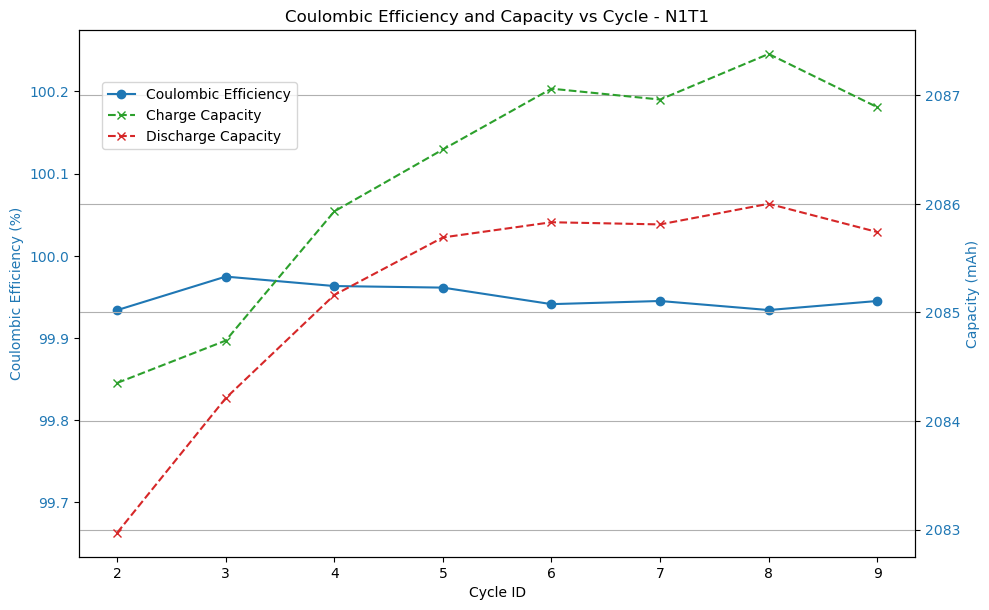

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Cycle ID')
ax1.set_ylabel('Coulombic Efficiency (%)', color=color)
ax1.plot(df_ce['Cycle_ID'], df_ce['Coulombic_Efficiency'], color=color, 
         marker='o', label='Coulombic Efficiency')
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim((df_ce['Coulombic_Efficiency'].min()-0.3), (df_ce['Coulombic_Efficiency'].max()+0.3))

ax2 = ax1.twinx()
ax2.set_ylabel('Capacity (mAh)', color=color)
ax2.plot(df_ce['Cycle_ID'], df_ce['Charge_Capacity'], color='tab:green', 
         marker='x', linestyle='--', label='Charge Capacity')
ax2.plot(df_ce['Cycle_ID'], df_ce['Discharge_Capacity'], color='tab:red', 
         marker='x', linestyle='--', label='Discharge Capacity')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title(f'Coulombic Efficiency and Capacity vs Cycle - {file_name}')
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/CE-cycles_{file_name}.png', dpi=300)
plt.show()
    
    # return df_ce

### State of Health (SOH) Analysis [Processing & Plotting]

Calculate and visualize the state of health of the battery over cycles. Preview of DataFrame (df_SOH) is shown on the following output.

In [32]:
# df_SOH = DA04_Function_SOH(df_VQ_grouped,rated_capacity,file_name,result_folder)
#--------------------Processing & Plotting SOH over cycles---------------------
# def DA04_Function_SOH(df_VQ_grouped,rated_capacity,file_name,result_folder):

SOH_data = []
    
# Extract unique cycle numbers from the column names
cycle_columns = [col for col in df_VQ_grouped.columns if re.match(r'Cycle_\d+_', col)]
cycle_numbers = sorted({int(re.search(r'Cycle_(\d+)_', col).group(1)) for col in cycle_columns})

for cycle_id in cycle_numbers:
       
    cchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapChg'].dropna()
    cdchg = df_VQ_grouped[f'Cycle_{cycle_id}_CapDChg'].dropna()
        
    # Calculate SOH
    if cchg.max() > cdchg.max():
        max_capacity_per_cycle = cchg.max()
    else:
        max_capacity_per_cycle = cdchg.max()
            
    soh = (max_capacity_per_cycle / rated_capacity) * 100
        
    # Combine into a DataFrame
    SOH_data.append({
            'Cycle_ID': cycle_id,
            'Maximum_Capacity': max_capacity_per_cycle,
            'SOH': soh
            })
    
df_SOH = pd.DataFrame(SOH_data)
df_SOH.to_csv(f'{result_folder}/{file_name}/df_SOH_{file_name}.csv', index=False)
pd.set_option('display.max_columns', None)  # Show all columns   
print('DataFrame df_SOH preview: ',df_SOH.head(5))

DataFrame df_SOH preview:     Cycle_ID  Maximum_Capacity        SOH
0         1           2081.65  99.126190
1         2           2084.35  99.254762
2         3           2084.74  99.273333
3         4           2085.93  99.330000
4         5           2086.50  99.357143


Then visualize the SOH percentage of the battery over cycles by plotting it againsts cycle ID.

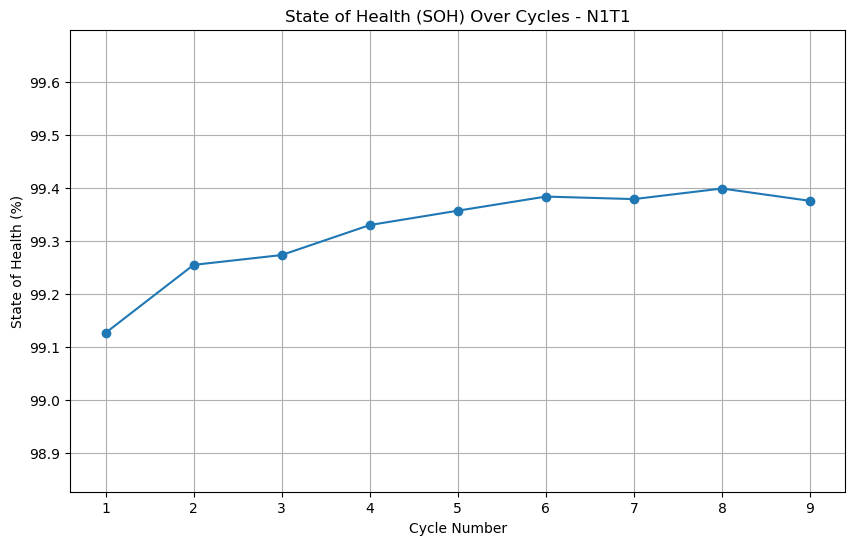

In [33]:
plt.figure(figsize=(10,6))
plt.plot(df_SOH['Cycle_ID'], df_SOH['SOH'], marker='o')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (%)')
plt.ylim((df_SOH['SOH'].min()-0.3), (df_SOH['SOH'].max()+0.3))
plt.title(f'State of Health (SOH) Over Cycles - {file_name}')
plt.grid(True)
plt.savefig(f'{result_folder}/{file_name}/SOH Plot_{file_name}.png', dpi=300)
plt.show()
        
    # return  df_SOH

### dQ/dV Analysis [Processing, Analysis, Plotting]

Perform dQ/dV analysis to study capacity degradation trends.

In [34]:
# Interpolation setup
interpolation_points = 300                                               # <=== Insert data point numbers for interpolation

# Smoothing setup             [Setup for Savitzky–Golay filter smoothing]
window_length = 5                                                        # <=== Insert the window length as the smoothing properties
polyorder = 1                                                            # <=== Insert the polyorder as the smoothing properties

# Finding peaks             [Setup parameter for finding peaks on dQ/dV-V plot]
min_prominence = 50                       #[Do not change if not necessary] <=== Insert the minimum prominence value
min_height = 50                           #[Do not change if not necessary] <=== Insert the minimum height value
max_prominence = 10000                    #[Do not change if not necessary] <=== Insert the maximum prominence value
max_height = 10000                        #[Do not change if not necessary] <=== Insert the maximum height value
prominence_step = 10                      #[Do not change if not necessary] <=== Insert the prominence value per iteration 
height_step = 10                          #[Do not change if not necessary] <=== Insert the height value per iteration            
max_iterations = 1000                     #[Do not change if not necessary] <=== Insert the maximum iteration number
max_peaks = 2                             #[Do not change if not necessary] <=== Insert the maximum expected peaks
    
window_size = 3                               #[Do not change if not necessary] <=== Insert the window size for gaussian fitting       

# Selecting parameters shown on plot
show_on_plot = [                                                           # <=== Insert the parameters to be shown on the plot: 
               # 'data'                                                    #      - 'data':from neware;
               'ori',                                                     #      - 'ori':pure calculation; 
               'int',                                                     #      - 'int':interpolated data; 
               'smooth',                                                  #      - 'smooth':interpolation,then filtering/smoothing  
                                                                          #         with Savitzky-Golay filter; 
               'peaks-fitting'                                            #      - 'peaks-fitting':notate peaks and plot Gaussian 
                                                                          #         fitting curve on the plot             
                ]
    
# df_dqdv,df_peaks,df_fitting = DA06_Function_dQdV(file_name,df_VQ_grouped,
#                                                  show_on_plot,
#                                                  interpolation_points,
#                                                  window_length,polyorder,
#                                                  window_size,min_prominence,
#                                                  min_height,max_prominence,
#                                                  max_height,prominence_step,
#                                                  height_step,max_iterations,
#                                                  max_peaks,result_folder)